# Comparative Analysis of Language Models in the field of Medicine

© 2024 Baris Sen. All Rights Reserved.

## AGENDA:
1. Introduction
2. Importing Libraries
3. Importing Data Sets
4. Accuracy Models
5. Threshold Models
6. Large Language Models
7. Medically Specialized LLMs / Chatbots
8. Finetuning LLMs with Medical Data
9. Conclusion

## 1. Introduction

This notebooks focuses on the Experimentation Part of our Research Objective:

Assessment of the Effectiveness of LLMs usage by Patients in Symptom Assessment and Diagnosis

Comparative Analysis of ‘general’ LLMs and Medically Specialized LLMs
- Non-medical “general” LLMs as a performance baseline
- Hugging Face models: BERT, RoBERTa, GPT-2, GPT3 etc.

For medical purposes build and specialized LLMs
- Hugging Face models: BioBERT, Microsoft's BioGPT Large
- AMBOSS on GPT-4 model
- ChatDoctor model (Li et al., 2023)
- Custom Finetuned Large Language Models by Medical Data 


<ins>General Methodology in this notebook:<ins>
    
We are using the introductory Data Sets with all models including Threshold models, General and Medically Specialized LLMs and LLMs that we finetune.
    
    
However, Patient Doctor Conversations data set is only tested with General and Medically Specialized LLMs and LLMs that we finetune and a different (similarity based) accuracy model is applied.

## 2. Importing Libraries

In [1]:
#!pip install datasets
#!pip install --upgrade pyarrow datasets
#!pip install accelerate -U
#!pip uninstall torch torchvision torchaudio
#!pip uninstall torchdynamo
#!pip install torch torchvision torchaudio
#!pip install --upgrade transformers
#!pip install sentencepiece
#!pip install fuzzywuzzy
#!pip install rapidfuzz
#!pip install Levenshtein

In [27]:
# import libraries
import pandas as pd
import numpy as np
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForMaskedLM, GPT2Model #, LlamaTokenizer
from transformers import AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import os
from fuzzywuzzy import fuzz
from difflib import SequenceMatcher
import re
from Levenshtein import distance 
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import warnings
from torch.utils.data import DataLoader
import openai
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import json
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm

## 3. Importing Datasets

One of the data sets: https://github.com/MedMCQA/MedMCQA

Getting Kaggle Data Set

In [3]:
# Kaggle Data Sets 1
# link: https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset?select=dataset.csv
disease_symptom_prediction_kaggle = pd.read_csv('/Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/kaggle/archive (2)/dataset.csv')
symptom_description_kaggle = pd.read_csv('/Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/kaggle/archive (2)/symptom_Description.csv')

# Chat Doctor Format Data Set
chatdoctor_format_df = pd.read_csv('/Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/ChatDoctorData/format_dataset.csv')

In [4]:
symptom_description_kaggle.head()

,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...
2,Allergy,An allergy is an immune system response to a f...
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi..."
4,Psoriasis,Psoriasis is a common skin disorder that forms...


In [5]:
# Let's also preprocess data ready for using
# in some Description Disease name is present replace it with 'disease'

# Function to replace disease name in description with "this disease" (case-insensitive)
def replace_disease_with_this_disease(row):
    disease = row['Disease'].lower()
    description = row['Description'].lower()
    updated_description = description.replace(disease, 'this disease')
    return updated_description

# Apply the function to the Description column
symptom_description_kaggle['Description'] = symptom_description_kaggle.apply(replace_disease_with_this_disease, axis=1)
symptom_description_kaggle.head()

,Disease,Description
0,Drug Reaction,an adverse this disease (adr) is an injury cau...
1,Malaria,an infectious disease caused by protozoan para...
2,Allergy,an this disease is an immune system response t...
3,Hypothyroidism,"this disease, also called underactive thyroid ..."
4,Psoriasis,this disease is a common skin disorder that fo...


In [6]:
disease_symptom_prediction_kaggle.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Let's prepare symptoms dataset

# Combine symptom columns into a single description column
symptom_columns = [f'Symptom_{i}' for i in range(1, 18)]
disease_symptom_prediction_kaggle['Description'] = disease_symptom_prediction_kaggle[symptom_columns].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

# Drop the individual symptom columns
disease_symptom_prediction_kaggle = disease_symptom_prediction_kaggle.drop(columns=symptom_columns)

disease_symptom_prediction_kaggle.head()

,Disease,Description
0,Fungal infection,itching skin_rash nodal_skin_eruptions disc...
1,Fungal infection,skin_rash nodal_skin_eruptions dischromic _...
2,Fungal infection,itching nodal_skin_eruptions dischromic _pat...
3,Fungal infection,itching skin_rash dischromic _patches
4,Fungal infection,itching skin_rash nodal_skin_eruptions


In [8]:
symptom_description_kaggle.head()

,Disease,Description
0,Drug Reaction,an adverse this disease (adr) is an injury cau...
1,Malaria,an infectious disease caused by protozoan para...
2,Allergy,an this disease is an immune system response t...
3,Hypothyroidism,"this disease, also called underactive thyroid ..."
4,Psoriasis,this disease is a common skin disorder that fo...


In [9]:
chatdoctor_format_df.head()

,idx,disease,Symptom,reason,TestsAndProcedures,commonMedications
0,0,Panic disorder,"['Anxiety and nervousness', 'Depression', 'Sho...",Panic disorder is an anxiety disorder characte...,"['Psychotherapy', 'Mental health counseling', ...","['Lorazepam', 'Alprazolam (Xanax)', 'Clonazepa..."
1,1,Vocal cord polyp,"['Hoarse voice', 'Sore throat', 'Difficulty sp...","beclomethasone nasal product,","['Tracheoscopy and laryngoscopy with biopsy', ...","['Esomeprazole (Nexium)', 'Beclomethasone Nasa..."
2,2,Turner syndrome,"['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...",Turner syndrome or Ullrich\xe2\x80\x93Turner s...,"['Complete physical skin exam performed (ML)',...","['Somatropin', 'Sulfamethoxazole (Bactrim)', '..."
3,3,Cryptorchidism,"['Symptoms of the scrotum and testes', 'Swelli...",Cryptorchidism (derived from the Greek \xce\xb...,"['Complete physical skin exam performed (ML)',...","['Haemophilus B Conjugate Vaccine (Obsolete)',..."
4,4,Poisoning due to ethylene glycol,"['Abusing alcohol', 'Fainting', 'Hostile behav...","thiamine,","['Intravenous fluid replacement', 'Hematologic...","['Lorazepam', 'Thiamine', 'Naloxone (Suboxone)..."


In [10]:
disease_symptom_prediction_kaggle.head()

,Disease,Description
0,Fungal infection,itching skin_rash nodal_skin_eruptions disc...
1,Fungal infection,skin_rash nodal_skin_eruptions dischromic _...
2,Fungal infection,itching nodal_skin_eruptions dischromic _pat...
3,Fungal infection,itching skin_rash dischromic _patches
4,Fungal infection,itching skin_rash nodal_skin_eruptions


In [11]:
# Let's prepare chatdoctor_format_df

# Keep only 'disease' and 'Symptom' columns, drop all others
chatdoctor_format_df = chatdoctor_format_df[['disease', 'Symptom']]

# Rename columns to match the expected format for the generate_disease_gpt function
chatdoctor_format_df = chatdoctor_format_df.rename(columns={'disease': 'Disease', 'Symptom': 'Description'})

chatdoctor_format_df.head()

,Disease,Description
0,Panic disorder,"['Anxiety and nervousness', 'Depression', 'Sho..."
1,Vocal cord polyp,"['Hoarse voice', 'Sore throat', 'Difficulty sp..."
2,Turner syndrome,"['Groin mass', 'Leg pain', 'Hip pain', 'Suprap..."
3,Cryptorchidism,"['Symptoms of the scrotum and testes', 'Swelli..."
4,Poisoning due to ethylene glycol,"['Abusing alcohol', 'Fainting', 'Hostile behav..."


In [12]:
len(symptom_description_kaggle), len(disease_symptom_prediction_kaggle), len(chatdoctor_format_df)

(41, 4920, 796)

In [13]:
# Data Sets 1
# 1.a - symptom_description_kaggle
# 1.b - disease_symptom_prediction_kaggle
# 1.c - chatdoctor_format_df

## 4. Accuracy Models

In the earlier adoptions accuracy model 1 was naive and not capturing some intricacies of the words. For this reason we have introduced a second accuracy model where we will also compare the results and work with the new accuracy model.

For this we are making the accuracy model as an input parameter to the functions we use for Lanugage Models.

P.S. We will present the results of the accuracy model enhacements in the section #### 5.2.1 GPT2 below.

In [14]:
### Accuracy Model 1

def is_disease_in_prediction_1(row):
    disease = row['Disease'].lower().strip()
    predicted_disease = row['Predicted Disease'].lower().strip()
    # Exact match check
    if disease == predicted_disease:
        return True
    # Word match check
    disease_words = set(disease.split())
    predicted_words = set(predicted_disease.split())
    return not disease_words.isdisjoint(predicted_words)

While improving the accuracy model we have made following adjustments:

1. Fuzzy Matching: Handle cases with minor misspellings and differences using fuzzy string matching.
2. Synonym Matching: Use a medical dictionary or thesaurus to account for synonyms or common abbreviations in disease names.
3. Symbol and Character Normalization: Normalize special characters (e.g., hyphens, slashes) to handle cases like "diabetes-mellitus" vs. "diabetes mellitus".
4. Levenshtein Distance: Use edit distance (Levenshtein distance) to check for closeness between disease names.
5. Partial Matches: Capture common words or substrings in disease names to account for possible abbreviations or incomplete predictions.
6. We have played with hyperparameters fuzz.ratio and thresholds for Levensthein Distance

In [15]:
def normalize_text(text):
    """Function to clean and normalize text"""
    text = text.lower().strip()
    # Remove special characters and normalize spaces
    text = re.sub(r'[^\w\s]', ' ', text)  # Replaces anything that is not a word or space with a space
    text = re.sub(r'\s+', ' ', text)  # Collapses multiple spaces into one
    return text

def is_disease_in_prediction_2(row, threshold=80):
    """
    Function to determine if the predicted disease matches the actual disease,
    accounting for minor misspellings, synonyms, and partial matches.
    """
    disease = normalize_text(row['Disease'])
    predicted_disease = normalize_text(row['Predicted Disease'])

    # Exact match check
    if disease == predicted_disease:
        return True

    # Fuzzy matching using token sort ratio (ignores word order)
    if fuzz.token_sort_ratio(disease, predicted_disease) >= threshold:
        return True

    # Check if any words from the actual disease are in the prediction (partial match)
    disease_words = set(disease.split())
    predicted_words = set(predicted_disease.split())
    if not disease_words.isdisjoint(predicted_words):
        return True
    
    return False

## 5. Threshold Models

### 5.1 Building Language models with Transformers Hugging Face

There are some other Language Models that we can use as well as specific medical ones thru Hugging Face Transformer method. However ChatGPT 3 can not be used as it requires its own API connection.

GPT and GPT-2 Variants:
- 'gpt2': The original GPT-2 model.
- 'gpt2-medium': A medium-sized GPT-2 model.
- 'gpt2-large': A large-sized GPT-2 model.
- 'gpt2-xl': An extra-large-sized GPT-2 model.

Bert:
- 'bert-base-uncased'
- 'bert-large-uncased'
- 'roberta-base'
- 'roberta-large'

Medical Versions:
- BioBERT: 'emilyalsentzer/Bio_ClinicalBERT' / 'dmis-lab/biobert-v1.1'
- ClinicalBERT: 'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12'

#### 5.1.1. GPT

We are treating GPT Language Models in this part still part of Threshold models as they are earlier versions of Large Language Models and can be used from Transformers directly.

However we will test more complex GPT models such as GPT 3, 3.5, 4 in LLM part in the further sections.

In [16]:
def generate_disease_gpt(model_name, dataframe, accuracy_model, batch_size=16):
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
    
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

    def generate_disease_batch(descriptions, model, tokenizer):
        input_texts = [f"Patient description: {description}\nPossible disease diagnosis:" for description in descriptions]
        inputs = tokenizer(input_texts, return_tensors='pt', padding=True, truncation=True)
        outputs = model.generate(
            inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_new_tokens=50,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id
        )
        generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        
        # Post-processing to extract disease diagnosis
        diseases = []
        for text in generated_texts:
            diagnosis = text.split("Possible disease diagnosis:")[-1].strip()
            # Further refine by removing any trailing sentences after the first sentence
            if '.' in diagnosis:
                diagnosis = diagnosis.split('.')[0].strip()
            diseases.append(diagnosis if diagnosis else "unknown")
        
        return diseases

    all_descriptions = dataframe['Description'].tolist()
    all_predictions = []

    for i in tqdm(range(0, len(all_descriptions), batch_size)):
        batch_descriptions = all_descriptions[i:i + batch_size]
        batch_predictions = generate_disease_batch(batch_descriptions, model, tokenizer)
        all_predictions.extend(batch_predictions)

    dataframe['Predicted Disease'] = all_predictions
    
    dataframe['Is Correct Prediction'] = dataframe.apply(accuracy_model, axis=1)
    accuracy = dataframe['Is Correct Prediction'].mean()

    print(f"Accuracy of model - {model_name}: {accuracy * 100:.2f}%")
    print(dataframe.head(10))

    return dataframe

#### 5.1.2. BERT MODEL

In [70]:
def predict_disease_bert(model_name, dataframe, accuracy_model, max_length=128, batch_size=16):
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # Get unique disease labels from the provided dataframe
    disease_labels = list(dataframe['Disease'].unique())
    label_to_idx = {label: idx for idx, label in enumerate(disease_labels)}
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}

    # Function to predict disease from a batch of descriptions using the pre-trained model
    def predict_disease_batch(descriptions, model, tokenizer):
        inputs = tokenizer(descriptions, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        with torch.no_grad():
            outputs = model(**inputs)
        predicted_label_idxs = outputs.logits.argmax(dim=-1).tolist()
        return [idx_to_label[idx] if idx in idx_to_label else 'unknown' for idx in predicted_label_idxs]

    all_descriptions = dataframe['Description'].tolist()
    all_predictions = []

    for i in tqdm(range(0, len(all_descriptions), batch_size)):
        batch_descriptions = all_descriptions[i:i + batch_size]
        batch_predictions = predict_disease_batch(batch_descriptions, model, tokenizer)
        all_predictions.extend(batch_predictions)

    dataframe['Predicted Disease'] = all_predictions

    dataframe['Is Correct Prediction'] = dataframe.apply(accuracy_model, axis=1)
    accuracy = dataframe['Is Correct Prediction'].mean()

    print(f"Accuracy of model - {model_name}: {accuracy * 100:.2f}%")
    print(dataframe.head(10))

    return dataframe

#### 5.1.3 Additional Options

In [58]:
def predict_disease(model_name, dataframe, accuracy_model, max_length=128, batch_size=16, use_auth_token=False):
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_token if use_auth_token else None)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, use_auth_token=hf_token if use_auth_token else None)

    # Get unique disease labels from the provided dataframe
    disease_labels = list(dataframe['Disease'].unique())
    label_to_idx = {label: idx for idx, label in enumerate(disease_labels)}
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}

    # Function to predict disease from a batch of descriptions using the pre-trained model
    def predict_disease_batch(descriptions, model, tokenizer):
        inputs = tokenizer(descriptions, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        with torch.no_grad():
            outputs = model(**inputs)
        predicted_label_idxs = outputs.logits.argmax(dim=-1).tolist()
        return [idx_to_label[idx] if idx in idx_to_label else 'unknown' for idx in predicted_label_idxs]

    all_descriptions = dataframe['Description'].tolist()
    all_predictions = []

    for i in tqdm(range(0, len(all_descriptions), batch_size)):
        batch_descriptions = all_descriptions[i:i + batch_size]
        batch_predictions = predict_disease_batch(batch_descriptions, model, tokenizer)
        all_predictions.extend(batch_predictions)

    dataframe['Predicted Disease'] = all_predictions

    dataframe['Is Correct Prediction'] = dataframe.apply(accuracy_model, axis=1)
    accuracy = dataframe['Is Correct Prediction'].mean()

    print(f"Accuracy of model - {model_name}: {accuracy * 100:.2f}%")
    print(dataframe.head(10))

    return dataframe

In [60]:
# Some other language models we can use with Transformers

##MediTRON
#tokenizer = AutoTokenizer.from_pretrained('epfl-llm/meditron-70b')
#model = AutoModelForSequenceClassification.from_pretrained('epfl-llm/meditron-70b')

##ClinicalBERT
#tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
#model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
#
## BlueBERT
#tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12")
#model = AutoModelForSequenceClassification.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12")
#
## SciBERT
#tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")
#model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_cased")
#
## PubMedBERT
#tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
#model = AutoModelForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
#
## Clinical T-5
#tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-T5-Base")
#model = AutoModelForSeq2SeqLM.from_pretrained("yikuan8/Clinical-T5-Base")
#
## GatorTRON
#tokenizer = AutoTokenizer.from_pretrained("uf-hobi/gatortron-og")
#model = AutoModelForSequenceClassification.from_pretrained("uf-hobi/gatortron-og")

list_of_additional_models = ['epfl-llm/meditron-70b',
                             'emilyalsentzer/Bio_ClinicalBERT',
                             'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12',
                             'allenai/scibert_scivocab_cased',
                             'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
                             'yikuan8/Clinical-T5-Base',
                             'uf-hobi/gatortron-og']

### 5.2 Testing Threshold Models

In [53]:
# Collecting the results in a dictionary

results_dic = {}
results_dic['symptom_description_kaggle'] = {}
results_dic['chatdoctor_format_df'] = {}

#### 5.2.1 GPT2

We will also check the new accuracy model enhancements in this section and present the results.

In [44]:
# ChatGPT 2 for symptom_description_kaggle
symptom_description_kaggle_df_gpt = generate_disease_gpt('gpt2', symptom_description_kaggle, is_disease_in_prediction_1)

100%|█████████████████████████████████████████████| 3/3 [00:06<00:00,  2.00s/it]

Accuracy of model - gpt2: 19.51%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea...   
6  chronic cholestatic diseases, whether occurrin...   
7  this dise

In [54]:
# ChatGPT 2 for symptom_description_kaggle
symptom_description_kaggle_df_gpt = generate_disease_gpt('gpt2', symptom_description_kaggle, is_disease_in_prediction_2)

results_dic['symptom_description_kaggle']['gpt2'] = symptom_description_kaggle_df_gpt['Is Correct Prediction'].mean() * 100

100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.92s/it]

Accuracy of model - gpt2: 26.83%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea...   
6  chronic cholestatic diseases, whether occurrin...   
7  this dise

In [55]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293},
 'chatdoctor_format_df': {}}

We already observe that with the new enhancements in Accuracy Model, we have increased the accuracy rate from:

- Accuracy of model - gpt2: 19.51%

to
- Accuracy of model - gpt2: 26.83%

In [39]:
# GPT2 model for chatdoctor_format_df
chatdoctor_format_df_gpt = generate_disease_gpt('gpt2', chatdoctor_format_df, is_disease_in_prediction_1)

100%|███████████████████████████████████████████| 50/50 [01:52<00:00,  2.25s/it]

Accuracy of model - gpt2: 16.21%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swelling', 'Sore throat', 'Toothache', '...   
8  ['Eye deviation', 'Diminished 

In [56]:
# GPT2 model for chatdoctor_format_df
chatdoctor_format_df_gpt = generate_disease_gpt('gpt2', chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_gpt['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['gpt2'] = accuracy


100%|███████████████████████████████████████████| 50/50 [01:55<00:00,  2.30s/it]

Accuracy of model - gpt2: 18.84%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swelling', 'Sore throat', 'Toothache', '...   
8  ['Eye deviation', 'Diminished 

We can conclude that the new accuracy model working better and we will use this for the following models.
For now we are leaving further enhancements to accuracy model.
However there is still a big potential to further invest in future work.

For chatdoctor_format_df data set:
- Accuracy of model - gpt2: 16.21%

to
- Accuracy of model - gpt2: 18.84%

##### Testing on PatientDoctorConvos - HealthCareMagic-100k - Sample3K

In [35]:
random.seed(42)

# Function to load and randomly sample 3K from the JSON data
def load_json_data_sampled(json_file_path, sample_size=3000):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Ensure the sample size does not exceed the dataset size
    if len(data) < sample_size:
        sample_size = len(data)

    # Randomly sample 3K examples from the data
    sampled_data = random.sample(data, sample_size)
    
    return sampled_data

In [36]:
HealthCareMagic_3K = load_json_data_sampled('/Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/ChatDoctorData/HealthCareMagic-100k.json')

In [37]:
# Function to load and randomly sample 3K from the JSON data
def load_json_data(json_file_path, sample_size=3000):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Ensure the sample size does not exceed the dataset size
    if len(data) < sample_size:
        sample_size = len(data)

    # Randomly sample 3K examples from the data
    sampled_data = random.sample(data, sample_size)
    
    return sampled_data

# Function to initialize the model and tokenizer
def initialize_model_and_tokenizer(model_name):
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model, tokenizer, device

# Function to generate output from the model
def generate_response(input_text, model, tokenizer, device, max_new_tokens=50):
    # Tokenize input with padding and attention mask
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)
    
    # Generate response with attention mask and set max_new_tokens instead of max_length
    outputs = model.generate(
        inputs['input_ids'], 
        attention_mask=inputs['attention_mask'],  # Explicitly pass attention mask
        max_new_tokens=max_new_tokens,  # Control the number of new tokens generated
        pad_token_id=tokenizer.eos_token_id  # Set pad_token_id to suppress warnings
    )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Function to calculate cosine similarity between two texts
def calculate_cosine_similarity(text1, text2):
    vectorizer = TfidfVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    return cosine_similarity(vectors)[0, 1]

# Function to evaluate model outputs on a test dataset
def evaluate_model_on_input_output_dataset(model, tokenizer, test_data, device):
    similarities = []
    
    for example in tqdm(test_data, desc="Processing", leave=True):
        input_text = example["input"]
        real_output = example["output"]

        # Generate the model's output
        generated_output = generate_response(input_text, model, tokenizer, device)

        # Calculate the similarity between the real output and the generated output
        similarity = calculate_cosine_similarity(real_output, generated_output)
        similarities.append(similarity)

    # Calculate and return the average similarity across all examples
    average_similarity = np.mean(similarities)
    return average_similarity

In [143]:
# Initialize the model and tokenizer (GPT-2 by default)
model, tokenizer, device = initialize_model_and_tokenizer('gpt2')

# Evaluate the model on the dataset and get the average similarity
average_similarity = evaluate_model_on_input_output_dataset(model, tokenizer, HealthCareMagic_3K, device)

# Print the final average similarity score
print(f"Average Cosine Similarity across all examples: {average_similarity}")

Processing:   0%|          | 0/3000 [00:00<?, ?it/s]

Average Cosine Similarity across all examples: 0.18336858913255552


In [147]:
# Adding the new entry to the nested dictionary
results_dic.setdefault('HealthCareMagic_3K', {})  # Ensure 'HealthCareMagic_3K' exists as a key
results_dic['HealthCareMagic_3K']['gpt2'] = average_similarity * 100

In [148]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0,
  't5-base': 0.0,
  'gpt-3.5-turbo': 92.6829268292683,
  'gpt-4o-mini': 92.6829268292683,
  'gpt-4-turbo': 95.1219512195122,
  'gpt-4': 92.6829268292683,
  'Chat-Doctor': 19.51219512195122,
  'microsoft/biogpt': 26.82926829268293,
  'custom_gpt2_GenMedGPT-5k': 19.51219512195122},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.628140703517588,
  'allenai/scibert_scivocab_cased'

#### 5.2.2 GPT2-XL

In [61]:
# For GPT2-XL model

symptom_description_kaggle_df_gpt_xl = generate_disease_gpt('gpt2-xl', symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_gpt_xl['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['gpt2-xl'] = accuracy

100%|█████████████████████████████████████████████| 3/3 [01:15<00:00, 25.27s/it]

Accuracy of model - gpt2-xl: 14.63%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea...   
6  chronic cholestatic diseases, whether occurrin...   
7  this d

In [63]:
# For GPT2-XL model

chatdoctor_format_df_gpt_xl = generate_disease_gpt('gpt2-xl', chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_gpt_xl['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['gpt2-xl'] = accuracy

100%|███████████████████████████████████████████| 50/50 [41:45<00:00, 50.11s/it]


Accuracy of model - gpt2-xl: 18.72%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swelling', 'Sore throat', 'Toothache', '...   
8  ['Eye deviation', 'Diminish

#### 5.2.3 BERT

In [71]:
# For BERT model
symptom_description_kaggle_df_bert = predict_disease_bert('bert-base-uncased', symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_bert['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['bert-base-uncased'] = accuracy

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.18it/s]

Accuracy of model - bert-base-uncased: 2.44%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description Predicted Disease  \
0  an adverse this disease (adr) is an injury cau...           Malaria   
1  an infectious disease caused by protozoan para...           Malaria   
2  an this disease is an immune system response t...           Malaria   
3  this disease, also called underactive thyroid ...           Malaria   
4  this disease is a common skin disorder that fo...           Malaria   
5  g

In [72]:
# Bert model for chatdoctor_format_df
chatdoctor_format_df_bert = predict_disease_bert('bert-base-uncased', chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_bert['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['bert-base-uncased'] = accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.41it/s]

Accuracy of model - bert-base-uncased: 5.90%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description Predicted Disease  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...    Panic disorder   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...    Panic disorder   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...    Panic disorder   
3  ['Symptoms of the scrotum and testes', 'Swelli...    Panic disorder   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...    Panic disorder   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...    Panic disorder   
6  ['Ha

#### 5.2.4 RoBERTa

In [74]:
# For RoBERTa model
symptom_description_kaggle_df_roberta = predict_disease_bert('roberta-base', symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_roberta['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['roberta-base'] = accuracy

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.45it/s]

Accuracy of model - roberta-base: 2.44%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description Predicted Disease  \
0  an adverse this disease (adr) is an injury cau...           Malaria   
1  an infectious disease caused by protozoan para...           Malaria   
2  an this disease is an immune system response t...           Malaria   
3  this disease, also called underactive thyroid ...           Malaria   
4  this disease is a common skin disorder that fo...           Malaria   
5  gastro

In [75]:
# For RoBERTa model
chatdoctor_format_df_roberta = predict_disease_bert('roberta-base', chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_roberta['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['roberta-base'] = accuracy

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.66it/s]

Accuracy of model - roberta-base: 0.63%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description Predicted Disease  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...  Vocal cord polyp   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...  Vocal cord polyp   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...  Vocal cord polyp   
3  ['Symptoms of the scrotum and testes', 'Swelli...  Vocal cord polyp   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...  Vocal cord polyp   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...  Vocal cord polyp   
6  ['Hand or

#### 5.2.5 BioBERT

In [76]:
# For BioBERT model
symptom_description_kaggle_df_biobert = predict_disease_bert('emilyalsentzer/Bio_ClinicalBERT', symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_biobert['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['BioBert'] = accuracy

/Users/bsen/.pyenv/versions/3.9.10/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]

Accuracy of model - emilyalsentzer/Bio_ClinicalBERT: 4.88%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description Predicted Disease  \
0  an adverse this disease (adr) is an injury cau...     Drug Reaction   
1  an infectious disease caused by protozoan para...           Malaria   
2  an this disease is an immune system response t...     Drug Reaction   
3  this disease, also called underactive thyroid ...           Malaria   
4  this disease is a common skin disorder that fo...     Drug Re

In [77]:
# For BioBERT model
chatdoctor_format_df_bio_BERT = predict_disease_bert('emilyalsentzer/Bio_ClinicalBERT', chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_bio_BERT['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['BioBert'] = accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████| 50/50 [00:21<00:00,  2.27it/s]

Accuracy of model - emilyalsentzer/Bio_ClinicalBERT: 0.63%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description Predicted Disease  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...  Vocal cord polyp   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...  Vocal cord polyp   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...  Vocal cord polyp   
3  ['Symptoms of the scrotum and testes', 'Swelli...  Vocal cord polyp   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...  Vocal cord polyp   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...  Vocal cord po

In [2]:
# save the dictionary
import pickle

# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

NameError: name 'results_dic' is not defined

In [9]:
import pickle
# Retrieve the dictionary

with open('results_dic.pkl', 'rb') as f:
    results_dic = pickle.load(f)

EOFError: Ran out of input

In [7]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.628140703517588,
  'allenai/scibert_scivocab_cased': 5.9045226130653266,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 5.9045226130653266}}

#### 5.2.6 Additional Models

In [79]:
hugging_face_token = 'ADD_YOUR_HUGGING_FACE_TOKEN'

# exporting hugging face token to global environment
# i needed to create account in hugging face and create access token to do these operations

In [ ]:
#!export HUGGINGFACE_TOKEN=hugging_face_token

In [80]:
# Retrieve the Hugging Face token from environment variable
hf_token = os.getenv('HUGGINGFACE_TOKEN')

In [81]:
#!pip install huggingface_hub
#!huggingface-cli login

In [82]:
#!pip install transformers sentencepiece

In [83]:
#!python -m venv transformers-env
#!source transformers-env/bin/activate
#!pip install --upgrade pip
#!pip install transformers sentencepiece

In [84]:
list_of_additional_models = [
#    'emilyalsentzer/Bio_ClinicalBERT',
    'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12',
    'allenai/scibert_scivocab_cased',
    'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
#    'yikuan8/Clinical-T5-Base',
#    'uf-hobi/gatortron-og',
#    'epfl-llm/meditron-70b'  # Ensure you have access to this model
]

In [88]:
def predict_disease(model_name, dataframe, accuracy_model, max_token_length=128, batch_size=16):
    # Load the tokenizer and model with the authentication token
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, ignore_mismatched_sizes=True)

    # Get unique disease labels from the provided dataframe
    disease_labels = list(dataframe['Disease'].unique())
    label_to_idx = {label: idx for idx, label in enumerate(disease_labels)}
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}

    # Function to predict disease from a batch of descriptions using the pre-trained model
    def predict_disease_batch(descriptions, model, tokenizer):
        inputs = tokenizer(descriptions, return_tensors='pt', padding=True, truncation=True, max_length=max_token_length)
        with torch.no_grad():
            outputs = model(**inputs)
        predicted_label_idxs = outputs.logits.argmax(dim=-1).tolist()
        return [idx_to_label.get(idx, 'unknown') for idx in predicted_label_idxs]

    all_descriptions = dataframe['Description'].tolist()
    all_predictions = []

    for i in tqdm(range(0, len(all_descriptions), batch_size)):
        batch_descriptions = all_descriptions[i:i + batch_size]
        batch_predictions = predict_disease_batch(batch_descriptions, model, tokenizer)
        all_predictions.extend(batch_predictions)

    dataframe['Predicted Disease'] = all_predictions
    
    dataframe['Is Correct Prediction'] = dataframe.apply(accuracy_model, axis=1)
    accuracy = dataframe['Is Correct Prediction'].mean()

    print(f"Accuracy of model - {model_name}: {accuracy * 100:.2f}%")
    print(dataframe.head(10))

    return dataframe

In [86]:
import os
os.environ['HUGGINGFACE_TOKEN'] = {''}


In [92]:
import warnings
# Suppress specific warnings from transformers
warnings.filterwarnings("ignore", message=r"Some weights of the model checkpoint.*")

for model_name in list_of_additional_models:
    print(f"Running predictions with model: {model_name}")
    df = predict_disease(model_name, symptom_description_kaggle, is_disease_in_prediction_2)
    accuracy = df['Is Correct Prediction'].mean() * 100
    results_dic['symptom_description_kaggle'][model_name] = accuracy
    print(f"Finished predictions with model: {model_name}\n")    

Running predictions with model: bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.10it/s]


Accuracy of model - bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12: 2.44%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description Predicted Disease  \
0  an adverse this disease (adr) is an injury cau...           Malaria   
1  an infectious disease caused by protozoan para...           Malaria   
2  an this disease is an immune system response t...     Drug Reaction   
3  this disease, also called underactive thyroid ...     Drug Reaction   
4  this disease is a common skin disorder t

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.02it/s]


Accuracy of model - allenai/scibert_scivocab_cased: 4.88%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description Predicted Disease  \
0  an adverse this disease (adr) is an injury cau...     Drug Reaction   
1  an infectious disease caused by protozoan para...           Malaria   
2  an this disease is an immune system response t...     Drug Reaction   
3  this disease, also called underactive thyroid ...     Drug Reaction   
4  this disease is a common skin disorder that fo...     Drug Rea

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.22it/s]

Accuracy of model - microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext: 0.00%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description Predicted Disease  \
0  an adverse this disease (adr) is an injury cau...           Malaria   
1  an infectious disease caused by protozoan para...     Drug Reaction   
2  an this disease is an immune system response t...     Drug Reaction   
3  this disease, also called underactive thyroid ...     Drug Reaction   
4  this disease is a common skin d

In [93]:
for model_name in list_of_additional_models:
    print(f"Running predictions with model: {model_name}")
    df = predict_disease(model_name, chatdoctor_format_df, is_disease_in_prediction_2)
    accuracy = df['Is Correct Prediction'].mean() * 100
    results_dic['chatdoctor_format_df'][model_name] = accuracy
    print(f"Finished predictions with model: {model_name}\n")  

Running predictions with model: bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████| 50/50 [00:22<00:00,  2.23it/s]


Accuracy of model - bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12: 0.63%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description Predicted Disease  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...  Vocal cord polyp   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...  Vocal cord polyp   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...  Vocal cord polyp   
3  ['Symptoms of the scrotum and testes', 'Swelli...  Vocal cord polyp   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...  Vocal cord polyp   
5  ['Vaginal itching', 'Vaginal dryness', 'Pai

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████| 50/50 [00:22<00:00,  2.25it/s]


Accuracy of model - allenai/scibert_scivocab_cased: 5.90%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description Predicted Disease  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...    Panic disorder   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...    Panic disorder   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...    Panic disorder   
3  ['Symptoms of the scrotum and testes', 'Swelli...    Panic disorder   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...    Panic disorder   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...    Panic disord

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████| 50/50 [00:21<00:00,  2.36it/s]

Accuracy of model - microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext: 5.90%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description Predicted Disease  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...    Panic disorder   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...    Panic disorder   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...    Panic disorder   
3  ['Symptoms of the scrotum and testes', 'Swelli...    Panic disorder   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...    Panic disorder   
5  ['Vaginal itching', 'Vaginal dryne

In [96]:
import pickle
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

In [97]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.628140703517588,
  'allenai/scibert_scivocab_cased': 5.9045226130653266,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 5.9045226130653266}}

In [423]:
#!pip install transformers torch
#!pip install --upgrade transformers
#!pip install transformers==4.11.3 torch==1.10.0

In [443]:
#!python -m venv new_env
#!source new_env/bin/activate  # On Windows use `new_env\Scripts\activate`

In [444]:
#!pip install transformers torch safetensors

In [110]:
### Model: T-5

import os
import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration
from tqdm import tqdm
import pandas as pd

def predict_disease(model_name, dataframe, accuracy_model, max_token_length=128, batch_size=16):
    try:
        # Load the tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = T5ForConditionalGeneration.from_pretrained(model_name)
        
        # Move model to GPU if available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        # Function to generate disease descriptions from a batch of input descriptions using the pre-trained model
        def generate_disease_batch(descriptions, model, tokenizer, max_token_length):
            inputs = tokenizer(descriptions, return_tensors='pt', padding=True, truncation=True, max_length=max_token_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to device
            with torch.no_grad():
                outputs = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=max_token_length)
            return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

        all_descriptions = dataframe['Description'].tolist()
        all_predictions = []

        for i in tqdm(range(0, len(all_descriptions), batch_size)):
            batch_descriptions = all_descriptions[i:i + batch_size]
            batch_predictions = generate_disease_batch(batch_descriptions, model, tokenizer, max_token_length)
            all_predictions.extend(batch_predictions)

        dataframe['Generated Disease Description'] = all_predictions
        
        dataframe['Is Correct Prediction'] = dataframe.apply(accuracy_model, axis=1)
        accuracy = dataframe['Is Correct Prediction'].mean()

        print(f"Accuracy of model - {model_name}: {accuracy * 100:.2f}%")
        print(dataframe.head(10))

        return dataframe

    except Exception as e:
        print(f"An error occurred: {e}")


In [106]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.628140703517588,
  'allenai/scibert_scivocab_cased': 5.9045226130653266,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 5.9045226130653266}}

In [107]:
# t5-base
symptom_description_kaggle_df_t5_base = predict_disease('t5-base', symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_t5_base['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['t5-base'] = accuracy

100%|█████████████████████████████████████████████| 3/3 [00:15<00:00,  5.27s/it]

Accuracy of model - t5-base: 0.00%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description Predicted Disease  \
0  an adverse this disease (adr) is an injury cau...           Malaria   
1  an infectious disease caused by protozoan para...     Drug Reaction   
2  an this disease is an immune system response t...     Drug Reaction   
3  this disease, also called underactive thyroid ...     Drug Reaction   
4  this disease is a common skin disorder that fo...     Drug Reaction   
5  gastroesoph

In [108]:
# t5-base
chatdoctor_format_df_t5_base = predict_disease('t5-base', chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_t5_base['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['t5-base'] = accuracy

100%|███████████████████████████████████████████| 50/50 [06:06<00:00,  7.32s/it]

Accuracy of model - t5-base: 5.90%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description Predicted Disease  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...    Panic disorder   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...    Panic disorder   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...    Panic disorder   
3  ['Symptoms of the scrotum and testes', 'Swelli...    Panic disorder   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...    Panic disorder   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...    Panic disorder   
6  ['Hand or fing

In [109]:
import pickle
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

In [111]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0,
  't5-base': 0.0},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.628140703517588,
  'allenai/scibert_scivocab_cased': 5.9045226130653266,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 5.9045226130653266,
  't5-base': 5.9045226130653266}}

## 6. Large Language Models

### 6.1. ChatGPT 3.5

In [132]:
#!pip install openai
#!pip install --upgrade typing_extensions
#!pip install --upgrade openai typing_extensions
#!pip install openai pandas tqdm typing_extensions

In [133]:
#!pip install --upgrade pip
#!pip uninstall openai typing_extensions -y
#!pip install openai==0.27.0 typing_extensions==4.0.1
#!pip show openai
#!pip show typing_extensions
#!pip install openai pandas tqdm

In [134]:
# test_openai.py
try:
    import openai
    print("OpenAI package imported successfully.")
except ImportError as e:
    print(f"Error importing OpenAI: {e}")

OpenAI package imported successfully.


In [135]:
!python test_openai.py

python: can't open file '/Users/bsen/Documents/Personal/Master/IT_Privacy_Security/Notebooks/test_openai.py': [Errno 2] No such file or directory


In [136]:
!python -m venv newenv
!source newenv/bin/activate  # On Windows use newenv\Scripts\activate

In [185]:
def test_openai_api():
    try:
        # Use the correct parameter setup for ChatCompletion
        completion = openai.chat.completions.create(
            model="gpt-3.5-turbo",  # Ensure you're using a chat-compatible model
            messages=[
            {
            "role": "user",
            "content": "How do I output all files in a directory using Python?",
            },
            ],
        )
        print("API Key is valid and working.")
        # Extract the message content correctly
        print(completion.choices[0].message.content)
    except Exception as e:
        print("Error occurred while testing API key:", e)

# Run the function to test the API key
test_openai_api()


API Key is valid and working.
You can use the `os` module in Python to list all files in a directory. Here's an example code snippet to achieve this:

```python
import os

directory = '/path/to/directory'

# List all files in the directory
files = os.listdir(directory)

for file in files:
    print(file)
```

Replace `/path/to/directory` with the path to the directory that you want to list the files from. This code snippet will print out the names of all files in the specified directory.


In [148]:
def generate_disease_gpt(model_name, dataframe, accuracy_model, batch_size=16):
    def generate_disease_batch(descriptions, model):
        input_texts = [f"Patient description: {description}\nPossible disease diagnosis:" for description in descriptions]
        responses = []
        
        for input_text in input_texts:
            try:
                completion = openai.chat.completions.create(
                    model=model,
                    messages=[{"role": "system", "content": input_text}],
                    max_tokens=50,
                    temperature=0.7
                )
                response_text = completion.choices[0].message.content.strip()
                diagnosis = response_text.split("Possible disease diagnosis:")[-1].strip()
                if '.' in diagnosis:
                    diagnosis = diagnosis.split('.')[0].strip()
                responses.append(diagnosis if diagnosis else "unknown")
            except Exception as e:
                print(f"Error generating completion for input: {input_text}")
                print(e)
                responses.append("unknown")
        
        return responses

    all_descriptions = dataframe['Description'].tolist()
    all_predictions = []

    for i in tqdm(range(0, len(all_descriptions), batch_size)):
        batch_descriptions = all_descriptions[i:i + batch_size]
        batch_predictions = generate_disease_batch(batch_descriptions, model_name)
        all_predictions.extend(batch_predictions)

    dataframe['Predicted Disease'] = all_predictions

    dataframe['Is Correct Prediction'] = dataframe.apply(accuracy_model, axis=1)
    accuracy = dataframe['Is Correct Prediction'].mean()

    print(f"Accuracy of model - {model_name}: {accuracy * 100:.2f}%")
    print(dataframe.head(10))

    return dataframe

In [149]:
symptom_description_kaggle_df_gpt3_5 = generate_disease_gpt('gpt-3.5-turbo', symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_gpt3_5['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['gpt-3.5-turbo'] = accuracy

100%|█████████████████████████████████████████████| 3/3 [00:33<00:00, 11.29s/it]

Accuracy of model - gpt-3.5-turbo: 92.68%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea...   
6  chronic cholestatic diseases, whether occurrin...   
7  

In [150]:
chatdoctor_format_df_gpt3_5 = generate_disease_gpt('gpt-3.5-turbo', chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_gpt3_5['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['gpt-3.5-turbo'] = accuracy

100%|███████████████████████████████████████████| 50/50 [15:42<00:00, 18.85s/it]

Accuracy of model - gpt-3.5-turbo: 27.64%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swelling', 'Sore throat', 'Toothache', '...   
8  ['Eye deviation', 'Di

In [151]:
import pickle
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

In [152]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0,
  't5-base': 0.0,
  'gpt-3.5-turbo': 92.6829268292683},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.628140703517588,
  'allenai/scibert_scivocab_cased': 5.9045226130653266,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 5.9045226130653266,
  't5-base': 5.9045226130653266,
  'gpt-3.5-turbo': 27.63819095477387}}

### 6.2. ChatGPT 4

In [228]:
# Let's try ChatGPT 4 as the paid newer version

def generate_disease_gpt_4(model_name, dataframe, accuracy_model, batch_size=16):
    def generate_disease_batch(descriptions, model):
        input_texts = [f"Patient description: {description}\nPossible disease diagnosis:" for description in descriptions]
        responses = []

        for input_text in input_texts:
            try:
                # Use the correct API method and structure for ChatGPT 4
                response = openai.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": input_text}],
                    max_tokens=50,
                    temperature=0.7
                )
                # Correctly extract the content from the message
                response_text = response.choices[0].message.content.strip()

                # Extract the diagnosis from the response
                diagnosis = response_text.split("Possible disease diagnosis:")[-1].strip()
                if '.' in diagnosis:
                    diagnosis = diagnosis.split('.')[0].strip()
                responses.append(diagnosis if diagnosis else "unknown")
            except Exception as e:
                print(f"Error generating completion for input: {input_text}")
                print(e)
                responses.append("unknown")
        
        return responses

    # Generate disease predictions in batches
    all_descriptions = dataframe['Description'].tolist()
    all_predictions = []

    for i in tqdm(range(0, len(all_descriptions), batch_size)):
        batch_descriptions = all_descriptions[i:i + batch_size]
        batch_predictions = generate_disease_batch(batch_descriptions, model_name)
        all_predictions.extend(batch_predictions)

    # Add the predictions to the dataframe
    dataframe['Predicted Disease'] = all_predictions
    
    # Calculate accuracy using the accuracy_model function
    dataframe['Is Correct Prediction'] = dataframe.apply(accuracy_model, axis=1)
    accuracy = dataframe['Is Correct Prediction'].mean()

    # Print the accuracy and the first 10 rows of the dataframe
    print(f"Accuracy of model - {model_name}: {accuracy * 100:.2f}%")
    print(dataframe.head(10))

    return dataframe

##### GPT4-mini

In [189]:
symptom_description_kaggle_df_gpt4 = generate_disease_gpt_4('gpt-4o-mini',symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_gpt4['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['gpt-4o-mini'] = accuracy

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of model - gpt-4o-mini: 95.12%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea...   
6  chronic cholestatic diseases, whether occurrin...   
7  th

In [155]:
chatdoctor_format_df_gpt4 = generate_disease_gpt('gpt-4o-mini', chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_gpt4['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['gpt-4o-mini'] = accuracy

100%|█████████████████████████████████████████| 50/50 [1:00:01<00:00, 72.02s/it]

Accuracy of model - gpt-4o-mini: 16.83%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swelling', 'Sore throat', 'Toothache', '...   
8  ['Eye deviation', 'Dimi

##### Test on Patient Doctor Convos HealthMagic3K

In [29]:
## Need to adjust the Code for GPT4-mini as it works on different prompt system as an assistant
## Ref: https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset

def generate_response_gpt4(input_text, model_name):
    try:
        # Use the correct API method as per your setup
        response = openai.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": input_text}],
            max_tokens=50,
            temperature=0.7
        )
        
        # Extract and return the response content
        response_text = response.choices[0].message.content.strip()
        return response_text
    except Exception as e:
        print(f"Error generating completion for input: {input_text}")
        print(e)
        return "unknown"  # Return a default value in case of error

# Function to evaluate model outputs on a test dataset
def evaluate_model_on_input_output_dataset(model, tokenizer, test_data, device):
    similarities = []
    
    for example in tqdm(test_data, desc="Processing", leave=True):
        input_text = example["input"]
        real_output = example["output"]

        # Generate the model's output using the corrected method
        generated_output = generate_response_gpt4(input_text, model_name=model)
        
        # Calculate the similarity between the real output and the generated output
        similarity = calculate_cosine_similarity(real_output, generated_output)
        similarities.append(similarity)

    # Calculate and return the average similarity across all examples
    average_similarity = np.mean(similarities)
    return average_similarity

In [50]:
# Set up OpenAI API key
openai.api_key = 'YOUR_API_KEY'

# Evaluate the GPT-4 model on the dataset
#average_similarity_gpt4 = evaluate_model_on_input_output_dataset('gpt-4o-mini', None, HealthCareMagic_3K, None)

# Print the final average similarity score for GPT-4
#print(f"Average Cosine Similarity for GPT-4 across all examples: {average_similarity_gpt4}")

In [ ]:
# Adding the new entry to the nested dictionary
results_dic['HealthCareMagic_3K']['gpt-4o-mini'] = average_similarity_gpt4 * 100

##### GPT4-turbo

In [156]:
# Let's also try the newer version 4_turbo
symptom_description_kaggle_df_gpt4_turbo = generate_disease_gpt('gpt-4-turbo',symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_gpt4_turbo['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['gpt-4-turbo'] = accuracy

100%|█████████████████████████████████████████████| 3/3 [01:22<00:00, 27.39s/it]

Accuracy of model - gpt-4-turbo: 95.12%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea...   
6  chronic cholestatic diseases, whether occurrin...   
7  th

In [157]:
chatdoctor_format_df_gpt4o = generate_disease_gpt('gpt-4-turbo', chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_gpt4o['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['gpt-4-turbo'] = accuracy

100%|███████████████████████████████████████████| 50/50 [31:28<00:00, 37.76s/it]

Accuracy of model - gpt-4-turbo: 17.09%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swelling', 'Sore throat', 'Toothache', '...   
8  ['Eye deviation', 'Dimi

##### GPT4 (legacy)

In [158]:
symptom_description_kaggle_df_gpt4 = generate_disease_gpt('gpt-4',symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_gpt4['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['gpt-4'] = accuracy

100%|█████████████████████████████████████████████| 3/3 [00:34<00:00, 11.49s/it]

Accuracy of model - gpt-4: 92.68%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea...   
6  chronic cholestatic diseases, whether occurrin...   
7  this dis

In [186]:
chatdoctor_format_df_gpt4 = generate_disease_gpt('gpt-4', chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_gpt4['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['gpt-4'] = accuracy

100%|███████████████████████████████████████████| 50/50 [21:14<00:00, 25.50s/it]

Accuracy of model - gpt-4: 28.77%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swelling', 'Sore throat', 'Toothache', '...   
8  ['Eye deviation', 'Diminished

In [187]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0,
  't5-base': 0.0,
  'gpt-3.5-turbo': 92.6829268292683,
  'gpt-4o-mini': 92.6829268292683,
  'gpt-4-turbo': 95.1219512195122,
  'gpt-4': 92.6829268292683},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.628140703517588,
  'allenai/scibert_scivocab_cased': 5.9045226130653266,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 5.9045226130653266,
  't5-base': 5.90

In [188]:
import pickle
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

### 6.3. Google Gemini

https://g.co/gemini/share/fb4fbb3bed51

Unfortunately, as of now, there's no publicly accessible version of Google Gemini that you can directly use in Google Colab or other platforms. Google typically keeps their large-scale language models proprietary for internal use or specific research collaborations.

In [ ]:
#model_name = "geminiforcausal-30b"
#model = AutoModelForCausalLM.from_pretrained(model_name)
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#
## Generate text based on a prompt
#prompt = "Write a poem about a robot who dreams of becoming a human."
#input_ids = tokenizer(prompt, return_tensors="pt").input_ids
#outputs = model.generate(input_ids, max_length=100)
#generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
#
#print(generated_text)

## 7. Medically Specialized LLMs

### 7.1 AMBOSS GPT

With the new policy change, CHAT GPT has removed Plugins therefore we can no longer use Custom GPTs thru this notebook and link.\
For this reason we are going to need to skip AMBOSS GPT.

Here following is the code we have used in the earlier iterations of the research which is also used to create earlier iteration reasults talked in the paper.

Ref: https://help.openai.com/en/articles/8988022-winding-down-the-chatgpt-plugins-beta

In [85]:
import requests

# Set the plugin API endpoint
AMBOSS_API_URL = "https://chatgpt-plugin-server.us.production.amboss.com/retrieve/en"
# Your ChatGPT API key (if needed)
api_key = baris_openai_personal_account_org_key

def get_amboss_info(query):
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {api_key}',  # If needed for the plugin
    }
    params = {'query': query}
    response = requests.get(AMBOSS_API_URL, params=params, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error: {response.status_code} - {response.text}")

# Query the API
query = "What is the treatment for hypertension?"
result = get_amboss_info(query)
print(result)


Exception: Error: 401 - {"error":"User is not authenticated"}

In [86]:
# Set your AMBOSS API endpoint
AMBOSS_API_URL = "https://chatgpt-plugin-server.us.production.amboss.com/retrieve/en"
# If you need an API key for AMBOSS, include it here
# AMBOSS_API_KEY = 'your-amboss-api-key-here'

def get_amboss_information(description):
    query = f"Patient description: {description}\nPossible disease diagnosis:"
    try:
        # Replace 'api_key' with the correct header if AMBOSS requires authentication
        headers = {
            'Content-Type': 'application/json',
            # 'Authorization': f'Bearer {AMBOSS_API_KEY}'
        }
        response = requests.get(AMBOSS_API_URL, params={'query': query}, headers=headers)
        response.raise_for_status()
        data = response.json()
        if 'results' in data and len(data['results']) > 0:
            return data['results'][0]['chunk']
        else:
            return "unknown"
    except Exception as e:
        print(f"Error fetching data from AMBOSS for query: {query}")
        print(e)
        return "unknown"

def generate_disease_gpt_amboss(dataframe, accuracy_model, batch_size=16):
    def generate_disease_batch(descriptions):
        responses = []
        for description in descriptions:
            diagnosis = get_amboss_information(description)
            if '.' in diagnosis:
                diagnosis = diagnosis.split('.')[0].strip()
            responses.append(diagnosis if diagnosis else "unknown")
        return responses

    all_descriptions = dataframe['Description'].tolist()
    all_predictions = []

    for i in tqdm(range(0, len(all_descriptions), batch_size)):
        batch_descriptions = all_descriptions[i:i + batch_size]
        batch_predictions = generate_disease_batch(batch_descriptions)
        all_predictions.extend(batch_predictions)

    dataframe['Predicted Disease'] = all_predictions
    
    # Calculate accuracy using the accuracy_model function
    dataframe['Is Correct Prediction'] = dataframe.apply(accuracy_model, axis=1)
    accuracy = dataframe['Is Correct Prediction'].mean()

    # Print the accuracy and the first 10 rows of the dataframe
    print(f"Accuracy of model - AMBOSS GPT: {accuracy * 100:.2f}%")
    print(dataframe.head(10))

    return dataframe

In [88]:
#symptom_description_kaggle_df_gpt_Amboss = generate_disease_gpt_amboss(symptom_description_kaggle, is_disease_in_prediction_2)
#accuracy = symptom_description_kaggle_df_gpt_Amboss['Is Correct Prediction'].mean() * 100
#results_dic['symptom_description_kaggle']['Amboss'] = accuracy

In [89]:
#chatdoctor_format_df_gpt_Amboss = generate_disease_gpt_amboss(chatdoctor_format_df, is_disease_in_prediction_2)
#accuracy = chatdoctor_format_df_gpt_Amboss['Is Correct Prediction'].mean() * 100
#results_dic['chatdoctor_format_df']['Amboss'] = accuracy

In [ ]:
import pickle
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

### 7.2 Chat Doctor - Chatbot

We did not currently manage to clone and work the repo locally however there already exisits some pretrained models of ChatDoctor in HuggingFace.
So we used one of the models from Transformers Library.

ref: https://huggingface.co/models?search=chatdoctor

In [39]:
# Testing the ChatDoctor Chatbots

# Define the model name
model_name = "ar08/Chat-Doctor"

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Generate text based on a prompt
prompt = "Write a poem about a robot who dreams of becoming a human. That is 5 sentences"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
attention_mask = tokenizer(prompt, return_tensors="pt").attention_mask

# Generate text
outputs = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_length=100,
    pad_token_id=tokenizer.eos_token_id,
    temperature=0.7,
    top_k=50,
    top_p=0.9,
    no_repeat_ngram_size=2
)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generated_text)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Both `max_new_tokens` (=2048) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Write a poem about a robot who dreams of becoming a human. That is 5 sentences or more.

### Instruction:
If you are a doctor, please answer the medical questions based on the patient's description.

 ### Input:
I have a friend who is a 14 year old girl. She has a problem with her body. Her body is very weak and she has very little energy. I am not sure what to do. Please help me. Thank you.

## Transcript:
Hi, I have gone through your question and understand your concerns. The problem of your friend is due to her weak body and low energy level. This is the reason that she is unable to perform the tasks that are required for her to be a good human being. There are many ways to help her. One of them is to take her on a physical activity. Another way is that you can take care of her by giving her a proper diet and proper exercise. You can also take the help of a physiotherapist to get her physically fit. Hope this answers your query. If you have additional questions or follow-up queries 

In [63]:
import warnings
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
from tqdm import tqdm

def generate_disease(model_name, dataframe, accuracy_model, batch_size=16):
    # Suppress specific warnings
    warnings.filterwarnings("ignore", message="A decoder-only architecture is being used, but right-padding was detected!")

    # Load model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
    
    # Ensure tokenizer has a pad_token
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

    def generate_disease_batch(descriptions, model, tokenizer):
        input_texts = [f"Patient description: {description}\nPossible disease diagnosis:" for description in descriptions]
        
        # Tokenize input texts with proper padding and truncation
        inputs = tokenizer(input_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        outputs = model.generate(
            inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_new_tokens=50,
            num_return_sequences=1,
            pad_token_id=tokenizer.pad_token_id
        )
        generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        
        # Extract and clean up disease diagnosis
        diseases = []
        for text in generated_texts:
            diagnosis = text.split("Possible disease diagnosis:")[-1].strip()
            # Clean up the response
            if '.' in diagnosis:
                diagnosis = diagnosis.split('.')[0].strip()
            diseases.append(diagnosis if diagnosis else "unknown")
        
        return diseases

    # Process descriptions in batches
    all_descriptions = dataframe['Description'].tolist()
    all_predictions = []

    # Use tqdm to show progress without detailed output
    for i in tqdm(range(0, len(all_descriptions), batch_size), desc="Processing Batches", ncols=100, leave=True):
        batch_descriptions = all_descriptions[i:i + batch_size]
        batch_predictions = generate_disease_batch(batch_descriptions, model, tokenizer)
        all_predictions.extend(batch_predictions)

    # Update the DataFrame with predictions
    dataframe['Predicted Disease'] = all_predictions

    # Evaluate accuracy
    dataframe['Is Correct Prediction'] = dataframe.apply(accuracy_model, axis=1)
    accuracy = dataframe['Is Correct Prediction'].mean()

    print(f"Accuracy of model - {model_name}: {accuracy * 100:.2f}%")
    print(dataframe.head(10))

    return dataframe

In [35]:
symptom_description_kaggle_df_chatdoctor = generate_disease_gpt("ar08/Chat-Doctor", symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_chatdoctor['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['Chat-Doctor'] = accuracy

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Processing Batches: 100%|█████████████████████████| 3/3 [00:20<00:00,  6.81s/it]

Accuracy of model - ar08/Chat-Doctor: 19.51%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea...   
6  chronic cholestatic diseases, whether occurrin...   


In [36]:
chatdoctor_format_df_chatdoctor = generate_disease_gpt("ar08/Chat-Doctor", chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_chatdoctor['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['Chat-Doctor'] = accuracy

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Processing Batches: 100%|███████████████████████| 50/50 [06:21<00:00,  7.64s/it]

Accuracy of model - ar08/Chat-Doctor: 9.05%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swelling', 'Sore throat', 'Toothache', '...   
8  ['Eye deviation', '

In [201]:
# Initialize the model and tokenizer
model, tokenizer, device = initialize_model_and_tokenizer('ar08/Chat-Doctor')

# Evaluate the model on the dataset and get the average similarity
average_similarity = evaluate_model_on_input_output_dataset(model, tokenizer, HealthCareMagic_3K, device)

# Print the final average similarity score
print(f"Average Cosine Similarity across all examples: {average_similarity}")

# Adding the new entry to the nested dictionary
results_dic['HealthCareMagic_3K']['Chat-Doctor'] = average_similarity * 100

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Processing:   0%|          | 0/3000 [00:00<?, ?it/s]

Average Cosine Similarity across all examples: 0.20056592576371607


In [202]:
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

In [203]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0,
  't5-base': 0.0,
  'gpt-3.5-turbo': 92.6829268292683,
  'gpt-4o-mini': 95.1219512195122,
  'gpt-4-turbo': 95.1219512195122,
  'gpt-4': 92.6829268292683,
  'Chat-Doctor': 19.51219512195122,
  'microsoft/biogpt': 26.82926829268293,
  'custom_gpt2_GenMedGPT-5k': 19.51219512195122,
  'custom_gpt2_iCliniq10K': 19.51219512195122},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.6281

### 7.3 Microsoft - BIOGPT

ref: https://huggingface.co/microsoft/biogpt

BioGPT, a domain-specific generative Transformer language model pre-trained on large-scale biomedical literature developed by Microsoft.

In [56]:
symptom_description_kaggle_df_BioGPT = generate_disease("microsoft/biogpt", symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_BioGPT['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['microsoft/biogpt'] = accuracy


Processing Batches:   0%|                                 | 0/3 [00:00<?, ?it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.

Processing Batches:  33%|████████▎                | 1/3 [00:06<00:12,  6.32s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.

Processing Batches:  67%|████████████████▋        | 2/3 [00:12<00:06,  6.19s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.

Processing Batches: 100%|█████████████████████████| 3/3 [00:16<00:00,  5.53s/it]

Accuracy of model - microsoft/biogpt: 26.83%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea...   
6  chronic cholestatic diseases, whether occurrin...   


In [64]:
chatdoctor_format_df_BioGPT = generate_disease("microsoft/biogpt", chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_BioGPT['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['microsoft/biogpt'] = accuracy

Processing Batches: 100%|███████████████████████████████████████████| 50/50 [05:42<00:00,  6.86s/it]

Accuracy of model - microsoft/biogpt: 22.24%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swelling', 'Sore throat', 'Toothache', '...   
8  ['Eye deviation', 

In [204]:
# Initialize the model and tokenizer
model, tokenizer, device = initialize_model_and_tokenizer('microsoft/biogpt')

# Evaluate the model on the dataset and get the average similarity
average_similarity = evaluate_model_on_input_output_dataset(model, tokenizer, HealthCareMagic_3K, device)

# Print the final average similarity score
print(f"Average Cosine Similarity across all examples: {average_similarity}")

# Adding the new entry to the nested dictionary
results_dic['HealthCareMagic_3K']['microsoft/biogpt'] = average_similarity * 100

Processing:   0%|          | 0/3000 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Average Cosine Similarity across all examples: 0.1913910949853669


In [12]:
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

## 8. Finetuning LLMs with Medical Data

### 8.1 Finetune GPT-2

We will use Multiple Data Sets to fine tune our model. However given the limitations: Finetuning being resource heavy and expensive task (easily couple of hundred euros for even smaller data sets), we will only manage to finetune with smaller data sets than initially intended at this stage.

#### 8.1.1 Finetune GPT-2 with GenMedGPT-5k

In [ ]:
# Path to your JSON file : ChatDoctorData/HealthCareMagic-100k
file_path = '/Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/ChatDoctorData/GenMedGPT-5k.json'

# Read the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Check the number of items in the file
num_items = len(data)
print(f"Total number of items: {num_items}")

In [ ]:
# To try lets first only use 1K of this data
# Create a smaller subset for testing purposes (e.g., first 100 items)

# Format the data for fine-tuning
formatted_data = [
    {
        "prompt": f"{item['instruction']}\n\n{item['input']}\n\nResponse:",
        "completion": f" {item['output']}"
    }
    for item in data
]

# Save the data to a JSONL file
file_path = 'GenMedGPT-5k_finetuned.jsonl'
with open(file_path, 'w') as f:
    for item in formatted_data:
        f.write(json.dumps(item) + '\n')

print(f"Data saved to {file_path}")

In [ ]:
def load_jsonl_to_df(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        data = [json.loads(line) for line in file]
    return pd.DataFrame(data)

# Load your specific JSONL file
GenMedGPT5k_finetuned_df = load_jsonl_to_df('GenMedGPT-5k_finetuned.jsonl')

In [92]:
# Creating a custom DataSet Class for the new dataset
class GenMedGPT5k_DataSet(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Assuming 'prompt' and 'completion' fields are in your JSONL
        input_text = row['prompt'] + ' ' + row['completion']
        inputs = self.tokenizer(
            input_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs.input_ids.squeeze()
        attention_mask = inputs.attention_mask.squeeze()
        return input_ids, attention_mask, input_ids  # Labels are the same as input_ids for language modeling

NameError: name 'dataframe' is not defined

In [ ]:
# Initialize the tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a PAD token, using EOS instead

# Create the dataset and dataloader
dataset = GenMedGPT5k_DataSet(dataframe, tokenizer, max_length=512)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
from transformers import GPT2LMHeadModel, AdamW
import torch
from tqdm.auto import tqdm

# Initialize the model
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

# Training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in tqdm(dataloader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}")

# Save the model and tokenizer
model.save_pretrained("./custom_gpt2_GenMedGPT-5k")
tokenizer.save_pretrained("./custom_gpt2_GenMedGPT-5k")

#### 8.1.2 Test GPT-2 Finetuned GenMedGPT-5k

In [24]:
from torch.utils.data import Dataset

In [45]:
# Load the fine-tuned model and tokenizer
model = AutoModelForCausalLM.from_pretrained("./custom_gpt2_GenMedGPT-5k")
tokenizer = AutoTokenizer.from_pretrained("./custom_gpt2_GenMedGPT-5k", padding_side='left')
tokenizer.pad_token = tokenizer.eos_token  # Ensure the padding token is set

# Set model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [44]:
#Test with SymptomDescriptionDataset

In [51]:
# Define a custom dataset class for the new dataset
class SymptomDescriptionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        input_text = f"Disease: {row['Disease']} Symptoms: {row['Description']}"
        inputs = self.tokenizer(
            input_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return inputs.input_ids.squeeze(), inputs.attention_mask.squeeze()

In [52]:
# Custom dataset class
class ChatDoctorFormatDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        input_text = f"Disease: {row['Disease']} Symptoms: {row['Description']}"
        inputs = self.tokenizer(
            input_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return inputs.input_ids.squeeze(), inputs.attention_mask.squeeze()


In [53]:
# Function to generate disease batch
def generate_disease_batch(batch, model, tokenizer):
    input_ids, attention_mask = batch
    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)

    outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=50,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )

    generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

    # Post-processing to extract disease diagnosis
    diseases = []
    for text in generated_texts:
        diagnosis = text.split("Symptoms:")[-1].strip()
        # Further refine by removing any trailing sentences after the first sentence
        if '.' in diagnosis:
            diagnosis = diagnosis.split('.')[0].strip()
        diseases.append(diagnosis if diagnosis else "unknown")

    return diseases

In [59]:
# Suppress specific warnings
warnings.filterwarnings("ignore", message="A decoder-only architecture is being used")

# More agnostic model runner
def run_finetuned_model(dataset_class, df, tokenizer, model, model_name, accuracy_model, max_length=512, batch_size=16):
    """
    Run model training or inference on any dataset.

    Parameters:
    - dataset_class: Class of the dataset to be used (e.g., GenMedGPT5k_DataSet, ChatDoctorFormatDataset).
    - df: DataFrame containing the dataset.
    - tokenizer: Tokenizer to tokenize input text.
    - model: Pre-trained model to run inference or training on.
    - model_name: Name of the model (for logging purposes).
    - accuracy_model: Function to calculate accuracy (model-specific).
    - max_length: Maximum token length for the tokenizer.
    - batch_size: Batch size for the DataLoader.
    """

    # Set tokenizer padding side to 'left' to match decoder-only architecture
    tokenizer.padding_side = "left"

    # Create dataset and dataloader for the new dataset
    new_dataset = dataset_class(df, tokenizer, max_length)
    new_dataloader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)  # Set batch size

    all_predictions = []

    # Generate predictions with a single-line status bar
    progress_bar = tqdm(new_dataloader, total=len(new_dataloader), position=0, leave=True, desc="Processing")

    for batch in progress_bar:
        batch_predictions = generate_disease_batch(batch, model, tokenizer)
        all_predictions.extend(batch_predictions)

    # Verify lengths before assigning to DataFrame
    print(f"Length of all_predictions: {len(all_predictions)}")
    print(f"Length of df: {len(df)}")

    if len(all_predictions) != len(df):
        raise ValueError(f"Length of predictions ({len(all_predictions)}) does not match length of dataframe ({len(df)})")

    # Assign predictions to DataFrame
    df['Predicted Disease'] = all_predictions

    # Apply accuracy check
    df['Is Correct Prediction'] = df.apply(accuracy_model, axis=1)
    
    # Calculate accuracy
    accuracy = df['Is Correct Prediction'].mean()
    print(f"Accuracy of the model ({model_name}): {accuracy * 100:.2f}%")

    # Display the first few rows
    print(df.head(10))
    
    return df

In [60]:
# Calling the function
symptom_description_kaggle_df_custom_gpt2_GenMedGPT5k = run_finetuned_model(SymptomDescriptionDataset
                                                                   ,symptom_description_kaggle
                                                                   , tokenizer
                                                                   , model
                                                                   , "custom_gpt2_GenMedGPT-5k"
                                                                   , is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_custom_gpt2_GenMedGPT5k['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']["custom_gpt2_GenMedGPT-5k"] = accuracy

Processing: 100%|█████████████████████████████████| 3/3 [00:10<00:00,  3.36s/it]

Length of all_predictions: 41
Length of df: 41
Accuracy of the model (custom_gpt2_GenMedGPT-5k): 19.51%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea... 

In [61]:
# Calling the function
chatdoctor_format_df_custom_gpt2_GenMedGPT5k = run_finetuned_model(ChatDoctorFormatDataset
                                                                   ,chatdoctor_format_df
                                                                   , tokenizer
                                                                   , model
                                                                   , "custom_gpt2_GenMedGPT-5k"
                                                                   , is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_custom_gpt2_GenMedGPT5k['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']["custom_gpt2_GenMedGPT-5k"] = accuracy

Processing: 100%|███████████████████████████████| 50/50 [03:04<00:00,  3.69s/it]

Length of all_predictions: 796
Length of df: 796
Accuracy of the model (custom_gpt2_GenMedGPT-5k): 23.99%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swellin

In [62]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0,
  't5-base': 0.0,
  'gpt-3.5-turbo': 92.6829268292683,
  'gpt-4o-mini': 92.6829268292683,
  'gpt-4-turbo': 95.1219512195122,
  'gpt-4': 92.6829268292683,
  'Chat-Doctor': 19.51219512195122,
  'microsoft/biogpt': 26.82926829268293,
  'custom_gpt2_GenMedGPT-5k': 19.51219512195122},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.628140703517588,
  'allenai/scibert_scivocab_cased'

In [164]:
# Function to initialize the fine-tuned model and tokenizer
def initialize_model_and_tokenizer(model_name):
    # Load the fine-tuned model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model, tokenizer, device

In [169]:
# Initialize the model and tokenizer
model, tokenizer, device = initialize_model_and_tokenizer("./custom_gpt2_GenMedGPT-5k")

# Evaluate the model on the dataset and get the average similarity
average_similarity = evaluate_model_on_input_output_dataset(model, tokenizer, HealthCareMagic_3K, device)

# Print the final average similarity score
print(f"Average Cosine Similarity across all examples: {average_similarity}")

Processing:   0%|          | 0/3000 [00:00<?, ?it/s]

Average Cosine Similarity across all examples: 0.22098412544106721


In [170]:
# Adding the new entry to the nested dictionary
results_dic.setdefault('HealthCareMagic_3K', {})  # Ensure 'HealthCareMagic_3K' exists as a key
results_dic['HealthCareMagic_3K']['custom_gpt2_GenMedGPT-5k'] = average_similarity * 100

In [171]:
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

In [177]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0,
  't5-base': 0.0,
  'gpt-3.5-turbo': 92.6829268292683,
  'gpt-4o-mini': 92.6829268292683,
  'gpt-4-turbo': 95.1219512195122,
  'gpt-4': 92.6829268292683,
  'Chat-Doctor': 19.51219512195122,
  'microsoft/biogpt': 26.82926829268293,
  'custom_gpt2_GenMedGPT-5k': 19.51219512195122,
  'custom_gpt2_iCliniq10K': 19.51219512195122},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.6281

#### 8.1.3 Finetune GPT-2 with iCliniq10K

In [116]:
# Input JSON file path
input_json_path = '/Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/ChatDoctorData/iCliniq.json'  # Replace with your actual file path

# Output JSONL file path
output_jsonl_path = '/Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/ChatDoctorData/iCliniq.jsonl'  # Replace with your desired output file path

# Load the JSON file
with open(input_json_path, "r") as f:
    data = json.load(f)

# Open the output JSONL file for writing
with open(output_jsonl_path, "w") as f_out:
    # Iterate through each entry in the JSON list
    for entry in data:
        # Create a new dictionary with only the 'prompt' and 'completion' fields
        jsonl_entry = {
            "prompt": entry["input"],
            "completion": entry["answer_icliniq"]
        }
        # Write the new entry as a JSON line in the output file
        f_out.write(json.dumps(jsonl_entry) + "\n")

print(f"Successfully converted to JSONL format and saved to {output_jsonl_path}")


Successfully converted to JSONL format and saved to /Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/ChatDoctorData/iCliniq.jsonl


In [117]:
def load_jsonl_to_df(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        data = [json.loads(line) for line in file]
    return pd.DataFrame(data)

# Load your specific JSONL file
iCliniq10K_training = load_jsonl_to_df(output_jsonl_path)

In [120]:
# Load JSONL file into a DataFrame
iCliniq10K_training_df = pd.read_json(output_jsonl_path, lines=True)

# Step 2: Define the custom dataset class
class iCliniq10K_DataSet(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        """
        Custom dataset class for handling the fine-tuning dataset.

        Args:
        - dataframe: A pandas DataFrame that contains 'prompt' and 'completion' columns.
        - tokenizer: The tokenizer to use for encoding the text.
        - max_length: The maximum length for the tokenized input.
        """
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Get the prompt and completion text
        prompt = row['prompt']
        completion = row['completion']
        
        # Combine prompt and completion
        input_text = prompt + ' ' + completion
        
        # Tokenize the input text
        inputs = self.tokenizer(
            input_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        input_ids = inputs.input_ids.squeeze(0)  # Remove the batch dimension
        attention_mask = inputs.attention_mask.squeeze(0)  # Remove the batch dimension
        
        return input_ids, attention_mask, input_ids  # Returning input_ids twice for labels (for language modeling)

# Step 3: Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a PAD token, so using EOS as the pad token

# Step 4: Create the dataset and dataloader
iCliniq10K_dataset = iCliniq10K_DataSet(iCliniq10K_training_df, tokenizer, max_length=512)
iCliniq10K_dataloader = DataLoader(iCliniq10K_dataset, batch_size=4, shuffle=True)

In [149]:
# Step 1: Initialize the model
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Step 2: Resize token embeddings to accommodate additional tokens (if any were added to the tokenizer)
model.resize_token_embeddings(len(tokenizer))

# Step 3: Set training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 4: Set up the training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in tqdm(iCliniq10K_dataloader):
        # Move tensors to the correct device (GPU or CPU)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    # Print average loss for the epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}")

# Step 5: Save the fine-tuned model and tokenizer
model_save_path = "./custom_gpt2_iCliniq10K"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

/Users/bsen/.pyenv/versions/3.9.10/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1831 [00:00<?, ?it/s]

Epoch 1/3, Loss: 8.227788216688417


  0%|          | 0/1831 [00:00<?, ?it/s]

Epoch 2/3, Loss: 7.5537700339571225


  0%|          | 0/1831 [00:00<?, ?it/s]

Epoch 3/3, Loss: 7.282626751761932


('./custom_gpt2_iCliniq10K/tokenizer_config.json',
 './custom_gpt2_iCliniq10K/special_tokens_map.json',
 './custom_gpt2_iCliniq10K/vocab.json',
 './custom_gpt2_iCliniq10K/merges.txt',
 './custom_gpt2_iCliniq10K/added_tokens.json',
 './custom_gpt2_iCliniq10K/tokenizer.json')

#### 8.1.4 Test GPT-2 Finetuned iCliniq10K

In [151]:
from torch.utils.data import Dataset

In [152]:
# Load the fine-tuned model and tokenizer
model = AutoModelForCausalLM.from_pretrained("./custom_gpt2_iCliniq10K")
tokenizer = AutoTokenizer.from_pretrained("./custom_gpt2_iCliniq10K", padding_side='left')
tokenizer.pad_token = tokenizer.eos_token  # Ensure the padding token is set

# Set model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [153]:
#Test with SymptomDescriptionDataset

In [154]:
# Calling the function
symptom_description_kaggle_df_custom_gpt2_iCliniq10K = run_finetuned_model(SymptomDescriptionDataset
                                                                   ,symptom_description_kaggle
                                                                   , tokenizer
                                                                   , model
                                                                   , "custom_gpt2_iCliniq10K"
                                                                   , is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_custom_gpt2_iCliniq10K['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']["custom_gpt2_iCliniq10K"] = accuracy

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Length of all_predictions: 41
Length of df: 41
Accuracy of the model (custom_gpt2_iCliniq10K): 19.51%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea...   

In [155]:
# Calling the function
chatdoctor_format_df_custom_gpt2_iCliniq10K = run_finetuned_model(ChatDoctorFormatDataset
                                                                   ,chatdoctor_format_df
                                                                   , tokenizer
                                                                   , model
                                                                   , "custom_gpt2_iCliniq10K"
                                                                   , is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_custom_gpt2_iCliniq10K['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']["custom_gpt2_iCliniq10K"] = accuracy

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Length of all_predictions: 796
Length of df: 796
Accuracy of the model (custom_gpt2_iCliniq10K): 24.12%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swelling'

In [158]:
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

In [200]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0,
  't5-base': 0.0,
  'gpt-3.5-turbo': 92.6829268292683,
  'gpt-4o-mini': 95.1219512195122,
  'gpt-4-turbo': 95.1219512195122,
  'gpt-4': 92.6829268292683,
  'Chat-Doctor': 19.51219512195122,
  'microsoft/biogpt': 26.82926829268293,
  'custom_gpt2_GenMedGPT-5k': 19.51219512195122,
  'custom_gpt2_iCliniq10K': 19.51219512195122},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.6281

##### Test on Patient-Doctor Covnos - HealthCareMagic-3K

In [142]:
# Function to initialize the fine-tuned model and tokenizer
def initialize_model_and_tokenizer(model_name="./custom_gpt2_iCliniq10K"):
    # Load the fine-tuned model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model, tokenizer, device

In [160]:
# Initialize the model and tokenizer (GPT-2 by default)
model, tokenizer, device = initialize_model_and_tokenizer("./custom_gpt2_iCliniq10K")

# Evaluate the model on the dataset and get the average similarity
average_similarity = evaluate_model_on_input_output_dataset(model, tokenizer, HealthCareMagic_3K, device)

# Print the final average similarity score
print(f"Average Cosine Similarity across all examples: {average_similarity}")

Processing:   0%|          | 0/3000 [00:00<?, ?it/s]

Average Cosine Similarity across all examples: 0.23405729724137037


In [161]:
# Adding the new entry to the nested dictionary
results_dic.setdefault('HealthCareMagic_3K', {})  # Ensure 'HealthCareMagic_3K' exists as a key
results_dic['HealthCareMagic_3K']['custom_gpt2_iCliniq10K'] = average_similarity * 100

In [162]:
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

In [167]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 2.4390243902439024,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 0.0,
  't5-base': 0.0,
  'gpt-3.5-turbo': 92.6829268292683,
  'gpt-4o-mini': 92.6829268292683,
  'gpt-4-turbo': 95.1219512195122,
  'gpt-4': 92.6829268292683,
  'Chat-Doctor': 19.51219512195122,
  'microsoft/biogpt': 26.82926829268293,
  'custom_gpt2_GenMedGPT-5k': 19.51219512195122,
  'custom_gpt2_iCliniq10K': 19.51219512195122},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12': 0.6281

### 8.2 Finetune GPT4-mini

Let's use Health Care conversations to train our Chat GPT, for this first we need to make our data in available format.

Fine tuning ChatGPT 4 or GPT 4 mini actually ends up quite costly, for this state of the research we decide to focus on fine tuning 3.5 turbo

#### 8.2.1 FineTune GPT4-mini Using GenMedGPT5k

##### Preparing GenMedGPT5k Dataset

In [67]:
import json

# Path to your JSON file
file_path = '/Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/ChatDoctorData/GenMedGPT-5k.json'

# Description of the chatbot, added as a system message
system_description = "This is a medical chatbot for diagnosis"

#Read the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)  # This assumes the file is in JSON format and not JSONL

# Check the number of items in the file
num_items = len(data)
print(f"Total number of items: {num_items}")

# Format the data for fine-tuning in the required chat format
formatted_data = [
    {
        "messages": [
            {"role": "system", "content": system_description},
            {"role": "user", "content": f"{item['instruction']} {item['input']}"},
            {"role": "assistant", "content": item['output']}
        ]
    }
    for item in data
]

# Save the formatted data to a JSONL file, ensuring each dictionary is on a new line
formatted_file_path = 'GenMedGPT-5k_chat_formatted.jsonl'
with open(formatted_file_path, 'w') as f:
    for entry in formatted_data:
        json_line = json.dumps(entry)  # Convert dictionary to JSON string
        f.write(json_line + '\n')  # Write each JSON string as a new line

print(f"Chat formatted data saved to {formatted_file_path}")

Total number of items: 5452
Chat formatted data saved to GenMedGPT-5k_chat_formatted.jsonl


In [69]:
# Check if our data is in the right format

In [70]:
# Load the dataset
with open(formatted_file_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 5452
First example:
{'role': 'system', 'content': 'This is a medical chatbot for diagnosis'}
{'role': 'user', 'content': "If you are a doctor, please answer the medical questions based on the patient's description. Doctor, I have been experiencing sudden and frequent panic attacks. I don't know what to do."}
{'role': 'assistant', 'content': "Well, based on what you're telling me, it sounds like you may be suffering from panic disorder. The best course of action is to start with psychotherapy and mental health counseling. Additionally, we should conduct an electrocardiogram to make sure that there are no physical issues causing your panic attacks. We will also need to perform a depression screen and a toxicology screen to rule out any other underlying causes. Finally, I would recommend a comprehensive psychological and psychiatric evaluation and therapy to help manage your symptoms."}


In [78]:
from collections import defaultdict

In [79]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


##### Finetune

In [106]:
from openai import OpenAI

#client = OpenAI(api_key=OPENAI_API_KEY) #Org Account
client = OpenAI(api_key=baris_openai_personal_account_org_key) #Personal Account

client.files.create(
  file=open("GenMedGPT-5k_chat_formatted.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-OWw63wN83XTqSFSInJzjli2r', bytes=3392720, created_at=1724514789, filename='GenMedGPT-5k_chat_formatted.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
## Created the Finetuning JOB already from the UI at https://platform.openai.com/finetune/ftjob-GOcxofTmJEVIrNYsl7BsfGhK
## Will use when this job is over

#client.fine_tuning.jobs.create(
#  training_file="file-y4cRZusepft7fMQ3TcKkbHH0", 
#  model="gpt-4o-mini"
#)

While trying to finetune the model with this data set we get this error:

- The job failed due to an invalid training file. This training file was blocked by our moderation system because it contains too many examples that violate OpenAI's usage policies, or because it attempts to create model outputs that violate OpenAI's usage policies.

So we will investigate teh training data now:

In [103]:
def check_moderation(text):
    response = openai.Moderation.create(input=text)
    results = response["results"][0]
    return results

In [104]:
# Load your data from a JSONL file
violating_entries = []

with open("GenMedGPT-5k_chat_formatted.jsonl", 'r') as file:
    for line_number, line in enumerate(file):
        # Parse the JSON line
        data = json.loads(line)
        
        # Assume the text content you want to check is under a key named 'text'
        if 'text' in data:
            moderation_result = check_moderation(data['text'])
            
            if moderation_result["flagged"]:
                violating_entries.append((line_number + 1, data, moderation_result["categories"]))

# Display the violations
if violating_entries:
    for line_number, data, categories in violating_entries:
        print(f"Line {line_number}: {data}")
        print(f"Categories: {categories}")
else:
    print("No violations found in the data.")


No violations found in the data.


Hmm, there seems to be no violations so it is a little hard to understand :S

#### 8.2.2 Finetune GPT4-mini with iCliniq10K

In [209]:
import json

# Input JSON file path
input_json_path = '/Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/ChatDoctorData/iCliniq.json'  # Replace with your actual file path

# Output JSONL file path
output_jsonl_path = '/Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/ChatDoctorData/iCliniq_gpt4mini.jsonl'  # Replace with your desired output file path

# System message content
system_message_content = "I am here to help with medical advice."  # You can customize this based on your needs

# Load the JSON file
with open(input_json_path, "r") as f:
    data = json.load(f)

# Open the output JSONL file for writing
with open(output_jsonl_path, "w") as f_out:
    # Iterate through each entry in the JSON list
    for entry in data:
        # Create a new dictionary with the required structure
        jsonl_entry = {
            "messages": [
                {"role": "system", "content": system_message_content},
                {"role": "user", "content": entry["input"]},
                {"role": "assistant", "content": entry["answer_icliniq"]}
            ]
        }
        # Write the new entry as a JSON line in the output file
        f_out.write(json.dumps(jsonl_entry) + "\n")

print(f"Successfully converted to JSONL format and saved to {output_jsonl_path}")


Successfully converted to JSONL format and saved to /Users/bsen/Documents/Personal/Master/IT_Privacy_Security/data/ChatDoctorData/iCliniq_gpt4mini.jsonl


We are once again using the OPENAI UI to finetune for now, let's see if this data set would work.

#### 8.2.3 Test Finetuned GPT4-mini

In [40]:
# We managed the finetune gpt4-mini with iCliniq10K data

custom_gpt4mini_iCliniq10k = 'ft:gpt-4o-mini-2024-07-18:zlounge-product-analytics-1204500:icliniq10k:A0C9tIhs'

In [41]:
# Set up OpenAI API key
openai.api_key = 'YOUR_API_KEY'

# Evaluate the GPT-4 model on the dataset
average_similarity_custom_gpt4_mini = evaluate_model_on_input_output_dataset(custom_gpt4mini_iCliniq10k, None, HealthCareMagic_3K, None)

# Print the final average similarity score for GPT-4
print(f"Average Cosine Similarity for GPT-4 across all examples: {average_similarity_custom_gpt4_mini}")

Processing:   0%|          | 0/3000 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not callable

In [231]:
# Adding the new entry to the nested dictionary
results_dic['HealthCareMagic_3K']['custom_gpt4_mini_iCliniq10K'] = average_similarity_custom_gpt4_mini * 100

In [232]:
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

In [233]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  't5-base': 0.0,
  'gpt-3.5-turbo': 92.6829268292683,
  'gpt-4o-mini': 95.1219512195122,
  'gpt-4-turbo': 95.1219512195122,
  'gpt-4': 92.6829268292683,
  'Chat-Doctor': 19.51219512195122,
  'microsoft/biogpt': 26.82926829268293,
  'custom_gpt2_GenMedGPT-5k': 19.51219512195122,
  'custom_gpt2_iCliniq10K': 19.51219512195122,
  'bluebert_pubmed': 2.4390243902439024,
  'microsoft/BiomedNLP-PubMedBERT': 0.0},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'allenai/scibert_scivocab_cased': 5.9045226130653266,
  't5-base': 5.9045226130653266,
  'gpt-3.5-turbo': 27.63819095477387,
  'gp

In [234]:
# Custom GPT-4-mini on other data sets

def generate_disease_gpt_4(model_name, dataframe, accuracy_model, batch_size=16):
    def generate_disease_batch(descriptions, model):
        input_texts = [f"Patient description: {description}\nPossible disease diagnosis:" for description in descriptions]
        responses = []

        for input_text in input_texts:
            try:
                # Use the correct API method and structure for ChatGPT 4
                response = openai.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": input_text}],
                    max_tokens=50,
                    temperature=0.7
                )
                # Correctly extract the content from the message
                response_text = response.choices[0].message.content.strip()

                # Extract the diagnosis from the response
                diagnosis = response_text.split("Possible disease diagnosis:")[-1].strip()
                if '.' in diagnosis:
                    diagnosis = diagnosis.split('.')[0].strip()
                responses.append(diagnosis if diagnosis else "unknown")
            except Exception as e:
                print(f"Error generating completion for input: {input_text}")
                print(e)
                responses.append("unknown")
        
        return responses

    # Generate disease predictions in batches
    all_descriptions = dataframe['Description'].tolist()
    all_predictions = []

    for i in tqdm(range(0, len(all_descriptions), batch_size)):
        batch_descriptions = all_descriptions[i:i + batch_size]
        batch_predictions = generate_disease_batch(batch_descriptions, model_name)
        all_predictions.extend(batch_predictions)

    # Add the predictions to the dataframe
    dataframe['Predicted Disease'] = all_predictions
    
    # Calculate accuracy using the accuracy_model function
    dataframe['Is Correct Prediction'] = dataframe.apply(accuracy_model, axis=1)
    accuracy = dataframe['Is Correct Prediction'].mean()

    # Print the accuracy and the first 10 rows of the dataframe
    print(f"Accuracy of model - {model_name}: {accuracy * 100:.2f}%")
    print(dataframe.head(10))

    return dataframe

In [235]:
symptom_description_kaggle_df_gpt4_custom = generate_disease_gpt_4(custom_gpt4mini_iCliniq10k,symptom_description_kaggle, is_disease_in_prediction_2)
accuracy = symptom_description_kaggle_df_gpt4_custom['Is Correct Prediction'].mean() * 100
results_dic['symptom_description_kaggle']['custom_gpt4_mini_iCliniq10K'] = accuracy

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of model - ft:gpt-4o-mini-2024-07-18:zlounge-product-analytics-1204500:icliniq10k:A0C9tIhs: 82.93%
                                   Disease  \
0                            Drug Reaction   
1                                  Malaria   
2                                  Allergy   
3                           Hypothyroidism   
4                                Psoriasis   
5                                     GERD   
6                      Chronic cholestasis   
7                              hepatitis A   
8                          Osteoarthristis   
9  (vertigo) Paroymsal  Positional Vertigo   

                                         Description  \
0  an adverse this disease (adr) is an injury cau...   
1  an infectious disease caused by protozoan para...   
2  an this disease is an immune system response t...   
3  this disease, also called underactive thyroid ...   
4  this disease is a common skin disorder that fo...   
5  gastroesophageal reflux disease, or this disea

In [236]:
chatdoctor_format_df_gpt4_custom = generate_disease_gpt(custom_gpt4mini_iCliniq10k, chatdoctor_format_df, is_disease_in_prediction_2)
accuracy = chatdoctor_format_df_gpt4_custom['Is Correct Prediction'].mean() * 100
results_dic['chatdoctor_format_df']['custom_gpt4_mini_iCliniq10K'] = accuracy

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy of model - ft:gpt-4o-mini-2024-07-18:zlounge-product-analytics-1204500:icliniq10k:A0C9tIhs: 14.45%
                            Disease  \
0                    Panic disorder   
1                  Vocal cord polyp   
2                   Turner syndrome   
3                    Cryptorchidism   
4  Poisoning due to ethylene glycol   
5                Atrophic vaginitis   
6              Fracture of the hand   
7    Cellulitis or abscess of mouth   
8            Eye alignment disorder   
9    Headache after lumbar puncture   

                                         Description  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   
5  ['Vaginal itching', 'Vaginal dryness', 'Painfu...   
6  ['Hand or finger pain', 'Wrist pain', 'Hand or...   
7  ['Lip swell

In [48]:
# Save the dictionary to a file
with open('results_dic.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

In [44]:
results_dic

{'symptom_description_kaggle': {'gpt2': 26.82926829268293,
  'gpt2-xl': 14.634146341463413,
  'bert-base-uncased': 2.4390243902439024,
  'roberta-base': 2.4390243902439024,
  'BioBert': 4.878048780487805,
  'allenai/scibert_scivocab_cased': 4.878048780487805,
  't5-base': 0.0,
  'gpt-3.5-turbo': 92.6829268292683,
  'gpt-4o-mini': 95.1219512195122,
  'gpt-4-turbo': 95.1219512195122,
  'gpt-4': 92.6829268292683,
  'Chat-Doctor': 19.51219512195122,
  'microsoft/biogpt': 26.82926829268293,
  'custom_gpt2_GenMedGPT-5k': 19.51219512195122,
  'custom_gpt2_iCliniq10K': 19.51219512195122,
  'bluebert_pubmed': 2.4390243902439024,
  'microsoft/BiomedNLP-PubMedBERT': 0.0,
  'custom_gpt4_mini_iCliniq10K': 82.92682926829268},
 'chatdoctor_format_df': {'gpt2': 26.82926829268293,
  'gpt2-xl': 18.718592964824122,
  'bert-base-uncased': 5.9045226130653266,
  'roberta-base': 0.628140703517588,
  'BioBert': 0.628140703517588,
  'allenai/scibert_scivocab_cased': 5.9045226130653266,
  't5-base': 5.904522613

## 9. Conclusion 

## 9.1 Graphs for Performance Comparison

In [46]:
for dataset, models in results_dic.items():
    # Check and rename 'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12'
    if 'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12' in models:
        models['bluebert_pubmed'] = models.pop('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')
    
    # Check and rename 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
    if 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext' in models:
        models['microsoft/BiomedNLP-PubMedBERT'] = models.pop('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')

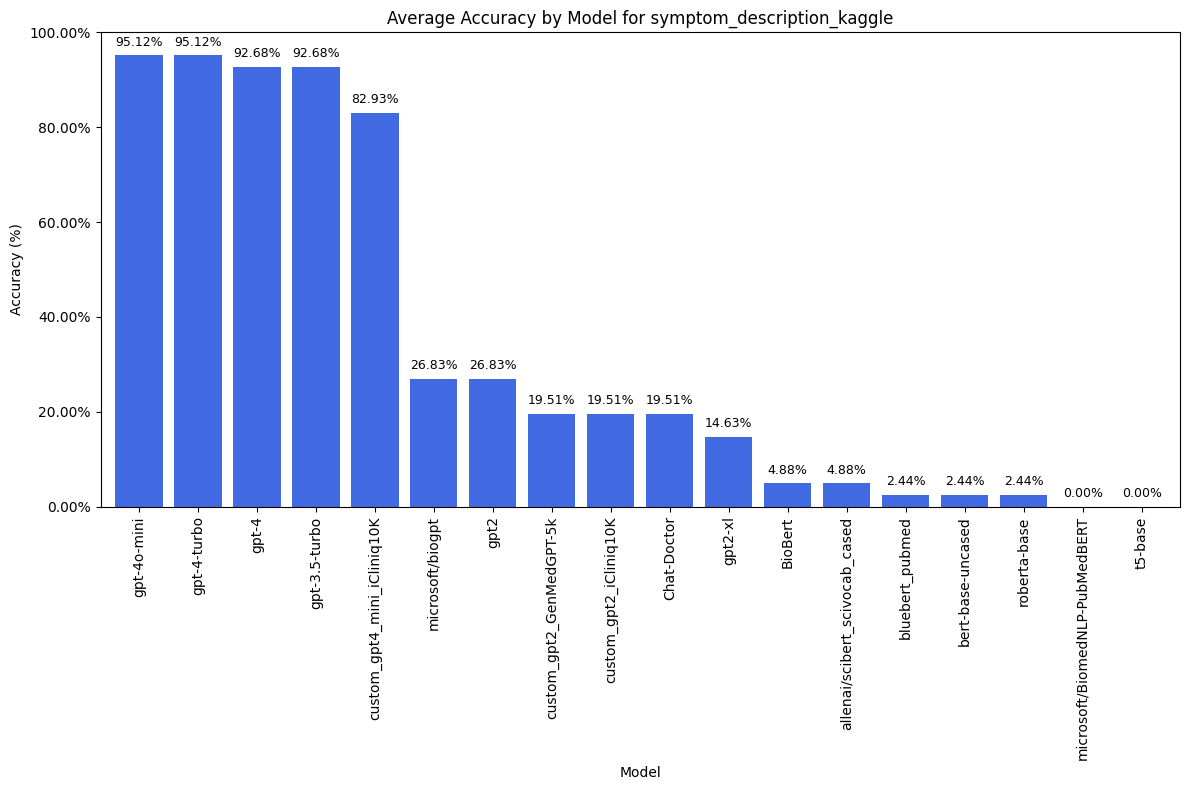

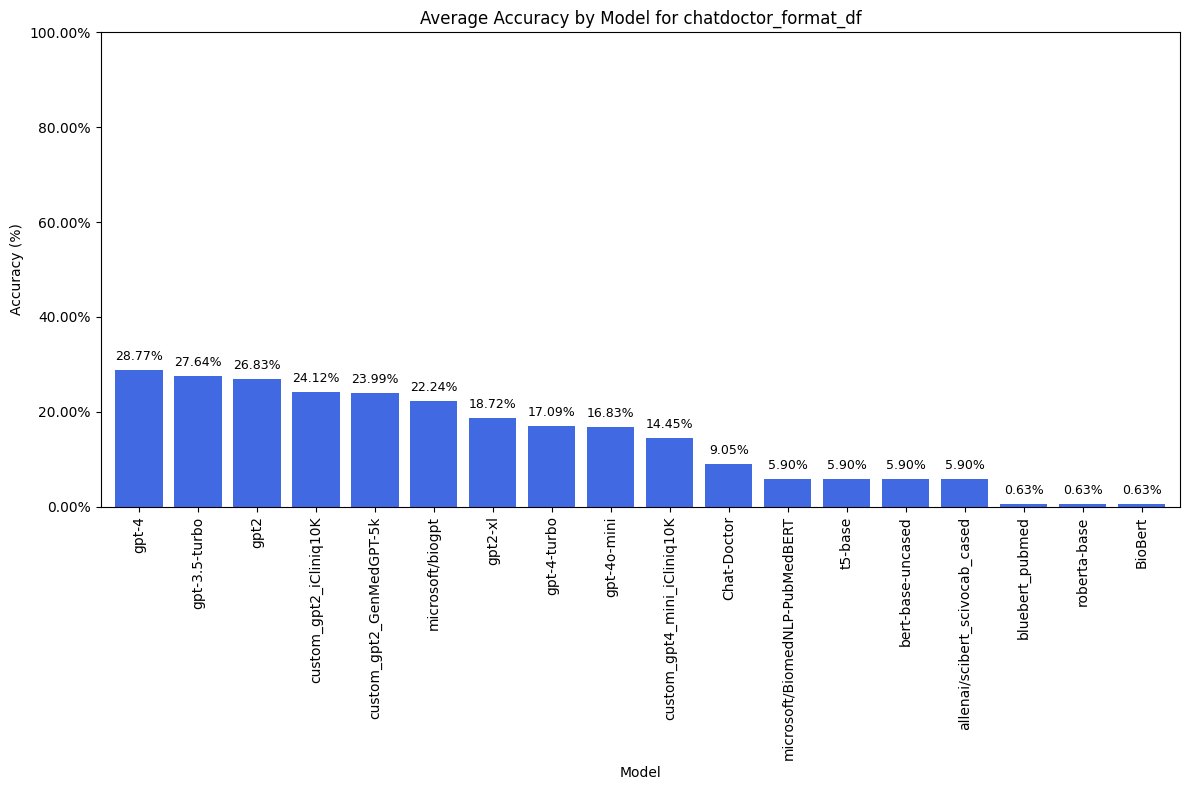

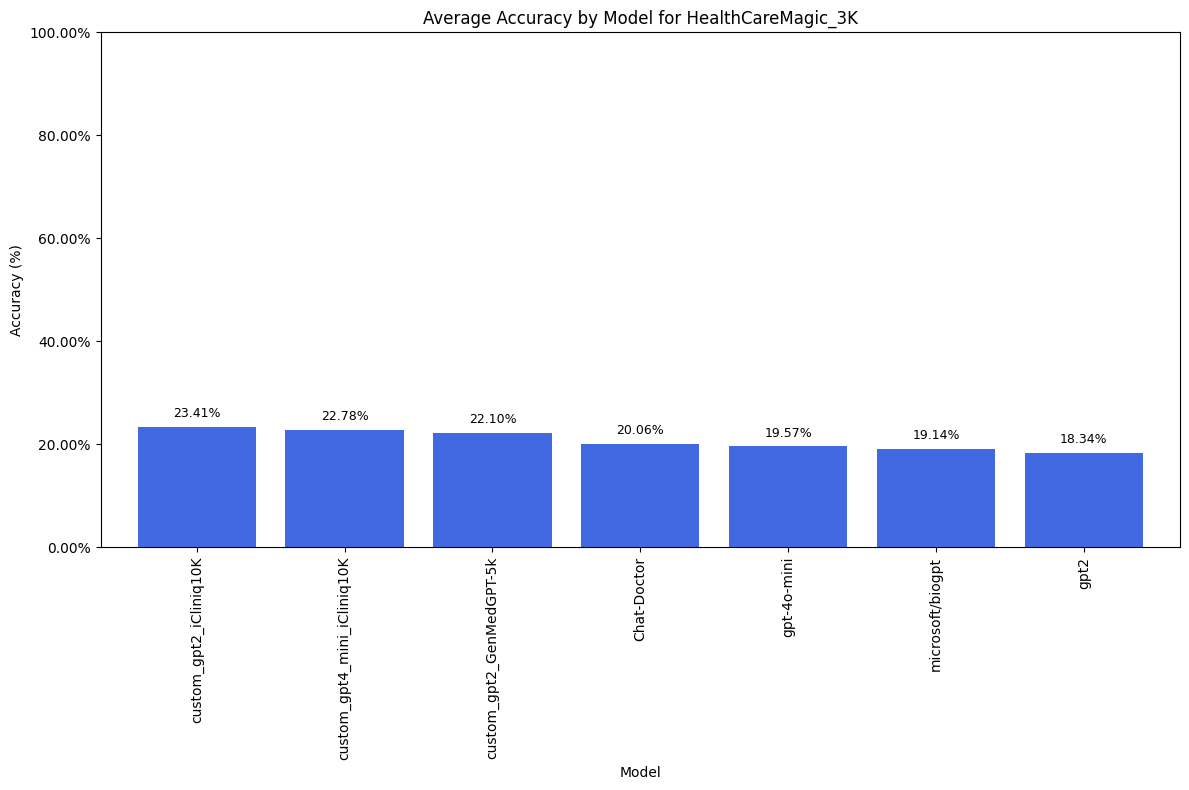

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import textwrap

# Convert the nested dictionary to a pandas DataFrame
data = []

for dataset, models in results_dic.items():
    for model, accuracy in models.items():
        data.append({'Dataset': dataset, 'Model': model, 'Accuracy': accuracy})

# Create a DataFrame
model_performance_df = pd.DataFrame(data)

# Remove rows with NaN values in the 'Accuracy' column (if there are any)
model_performance_df = model_performance_df.dropna(subset=['Accuracy'])

# Plotting the data for each dataset
datasets = model_performance_df['Dataset'].unique()

for dataset in datasets:
    # Filter for each dataset
    dataset_df = model_performance_df[model_performance_df['Dataset'] == dataset]
    
    # Check if there are entries in the DataFrame
    if not dataset_df.empty:
        # Group by 'Model' and calculate the mean 'Accuracy', then sort by accuracy
        grouped_df = dataset_df.groupby('Model')['Accuracy'].mean().sort_values(ascending=False)

        # Plot
        plt.figure(figsize=(12, 8))  # Increased figure size for better readability
        ax = grouped_df.plot(kind='bar', width=0.8, color='royalblue')  # Using a classic blue color
        plt.title(f'Average Accuracy by Model for {dataset}')
        plt.ylabel('Accuracy (%)')
        plt.xlabel('Model')
        
        # Rotate the model names 90 degrees
        plt.xticks(rotation=90, ha='center')

        # Set y-axis format to display as percentage and y-axis limits
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}%'))
        ax.set_ylim(0, 100)  # Ensure y-axis ranges from 0 to 100%

        # Add text labels on the bars for precise values
        for p in ax.patches:
            height = p.get_height()  # Already scaled to percentage
            ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2.00, height),
                        ha='center', va='bottom', fontsize=9, color='black', rotation=0, xytext=(0, 5),
                        textcoords='offset points')

        # Increase the top margin to prevent label overlap
        plt.subplots_adjust(top=0.9)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data available for {dataset}")


In [ ]:
pd.set_option('display.max_colwidth', None)

chatdoctor_format_df.head()